# BioNeMo - MolMIM Inferencing for Generative Chemistry

This tutorial describes the process of runing a Docker container with a pre-trained MolMIM model and using it for generative chemistry. At the end of this tutorial, you will learn:

- various functionalities provided in BioNeMo for obtaining chemical embeddings
- how to use the learned representations for generative AI and downstream predictive modeling tasks

For a detailed tutorial focusing specifically on property-guided molecular generation with the MolMIM model, please refer to [cma_es_guided_molecular_optimization_molmim.ipynb](cma_es_guided_molecular_optimization_molmim.ipynb).


<a id='contents'></a>
## Setting up MolMIM 



### Prerequisites:
- BioNeMo Framework container is running (refer to the [Quickstart Guide](../quickstart-fw.md))
- Familiarity with some components of the BioNeMo framework such as the [Models](../models/molmim.md) and [Inferencing](../inference-grpc-fw.md)
- **Assumption:** This notebook is being executed from within the BioNeMo docker image.


#### Downloading pre-trained models

```bash
python download_model.py --download_dir /workspace/bionemo/models molmim_70m_24_3
```


#### Copy this code and input files into JupyterLab

In the launched JupyterLab instance, run the Jupyter notebook provided in the code cells below, and copy the [`benchmark_MoleculeNet_ESOL.csv`](./benchmark_MoleculeNet_ESOL.csv) to the Jupyter-Lab working directory.

***
<a id='contents'></a>
## Overview

This walk-through will cover the following aspects of BioNeMo-MolMIM:

<a href='#section1'> **BioNeMo-MolMIM Inference Functions**</a>: 

- In this section, we will explore the key inference functionalities of the pre-trained model accessible through the __`Inference`__ wrapper over the model. 

These functionalities include obtaining latent space representations with __`seqs_to_hidden`__, embeddings with __`seqs_to_embedding`__, using input SMILES, as well as obtaining SMILES from latent space representations with __`hidden_to_seqs`__.
<br><br><br>

<a href='#section2'> **Molecule Generation / Chemical Space Exploration**</a>:

- Here, we will explore the chemical space around input query compound and generate related compounds.

<br><br>
![MolMIM Molecule Generation](../images/MolMIM_molecule_generation_1.png)
<br><br><br>


<a href='#section3'> **Using Embeddings for Predictive Modeling**</a>:  

- Finally, we will use the embeddings obtained from the BioNeMo-MolMIM for a chemical dataset as features to create a machine learning model to predict properties of the compounds. To evaluate the quality of these embeddings, we will also obtain Morgan Fingerprints to create a comparable baseline prediction model.

<br><br><br>
![MolMIM Molecule Generation](../images/MolMIM_molecule_generation_2.png)
<br><br><br>


***


**Note:** The following cells containing python code snippets can be directly copied and executed into a Python environment such as a Jupyter notebook running in a BioNemo container.

_**Importing required libraries**_

In the following cell, we import the libraries required to run the tasks for this tutorial. 

These imports include open-source CUDA-accelarated data science and machine learning libraries such as cuML, cuDF, cuPY. For more information, check out [NVIDIA RAPIDS](https://rapids.ai/). 

[cuDF](https://github.com/rapidsai/cudf) provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming. Similarly, [cuML](https://github.com/rapidsai/cuml) enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs. In most cases, cuML's Python API matches the API from scikit-learn.

Additionally, we will be using [RDKit](https://www.rdkit.org/) package, which is an open-source cheminformatics library.

In [1]:
# Importing required libraries from RAPIDS, Pandas and NumPy packages
import cuml
import cudf
import cupy as cp
from cuml import LinearRegression
from cuml.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import logging
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Importing libraries from RDKit for handling and manipulating chemical data
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
IPythonConsole.molSize=250,250

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject


<a id='section1'></a>

## BioNeMo-MolMIM Inference Functions:

### Setup the connection to the inference wrapper and providing example compounds

In this cell, we create a connection to the __`MolMIMInference`__ and access the inferencing functions. 

__`MolMIMInference`__ is an adaptor that allows interaction with the inference service of a BioNeMo-MolMIM pre-trained model.

[NeMo I 2024-03-22 16:17:20 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-03-22 16:17:20 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo I 2024-03-22 16:17:20 utils:326] Restoring model from /workspace/bionemo/models/molecule/molmim/molmim_70m_24_3.nemo
[NeMo I 2024-03-22 16:17:20 utils:330] Loading model class: bionemo.model.molecule.molmim.molmim_model.MolMIMModel
Interactive mode selected, using strategy='auto'


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[NeMo I 2024-03-22 16:17:20 exp_manager:394] Experiments will be logged at /workspace/bionemo/test_results/nemo_experiments/molmim_infer/MolMIM_Inference/2024-03-22_16-17-20
[NeMo I 2024-03-22 16:17:20 utils:299] 
    
    ************** Trainer configuration ***********
[NeMo I 2024-03-22 16:17:21 utils:300] 
    name: MolMIM_Inference
    desc: Minimum configuration for initializing a MolMIM model for inference.
    trainer:
      precision: 16-mixed
      devices: 1
      num_nodes: 1
      accelerator: gpu
      logger: false
      accumulate_grad_batches: 1
    exp_manager:
      explicit_log_dir: null
      exp_dir: ${oc.env:BIONEMO_HOME}/test_results/nemo_experiments/molmim_infer
      name: ${name}
      create_checkpoint_callback: false
      create_wandb_logger: false
      create_tensorboard_logger: false
      wandb_logger_kwargs:
        offline: true
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: 2048
        num_attentio

[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-03-22 16:17:21 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2024-03-22 16:17:21 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2024-03-22 16:17:21 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2024-03-22 16:17:21 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2024-03-22 16:17:21 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2024-03-22 16:17:21 megatron_init:257] Rank 0 has tensor model parallel group: [0]
[NeMo I 2024-03-22 16:17:21 megatron_init:261] All tensor model parallel group ranks: [[0]]
[NeMo I 2024-03-22 16:17:21 megatron_init:262] Rank 0 has tensor model parallel rank: 0
[NeMo I 2024-03-22 16:17:21 megatron_init:276] Rank 0 has pipeline model parallel group: [0]
[NeMo I 2024-03-22 16:17:21 megatron_init:288] Rank 0 has embedding group: [0]
[NeMo I 2024-03-22 16:17:21 megatron_init:294] All pipeline model parallel group ranks: [[0]]
[NeMo I 2024-03-22 16:17:21 megatron_init:295]

[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-03-22 16:17:21 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-03-22 16:17:21 tokenizer_utils:199] Using regex tokenization
[NeMo I 2024-03-22 16:17:21 regex_tokenizer:240] Loading vocabulary from file = /tmp/tmpzuw91mel/dd344353154640acbbaea1d4536fa7d0_molmim.vocab
[NeMo I 2024-03-22 16:17:21 regex_tokenizer:254] Loading regex from file = /tmp/tmpzuw91mel/048c1f797f464dd5b6a90f60f9405827_molmim.model
[NeMo I 2024-03-22 16:17:21 megatron_base_model:315] Padded vocab_size: 640, original vocab_size: 523, dummy tokens: 117.
[NeMo I 2024-03-22 16:17:21 megatron_hiddens:121] NOTE: Adding hiddens transforms and losses
[NeMo I 2024-03-22 16:17:21 megatron_hiddens:149] Added transform q_z_given_x with cfg={'cls_name': 'sampled_var_cond_gaussian', 'hidden_size': 512, 'min_logvar': -6.0, 'max_logvar': 0.0, 'map_var_to_hiddens': False}
[NeMo I 2024-03-22 16:17:21 megatron_hiddens:177] Added loss mim with cfg={'cls_name': 'a_mim', 'loss_weight': 1.0}
[NeMo I 2024-03-22 16:17:21 nlp_overrides:752] Model MolMIMModel was successfully restored from /

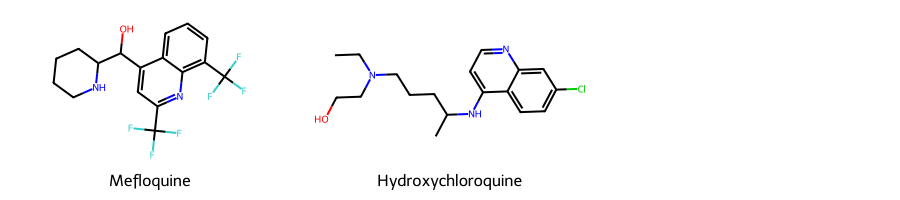

In [2]:
from bionemo.utils.hydra import load_model_config
import os
from bionemo.model.molecule.molmim.infer import MolMIMInference
bionemo_home=f"/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
checkpoint_path = f"{bionemo_home}/models/molecule/molmim/molmim_70m_24_3.nemo"
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/") # reasonable starting config for molmim inference
# This is the field of the config that we need to set to our desired checkpoint path.
cfg.model.downstream_task.restore_from_path = checkpoint_path
model = MolMIMInference(cfg, interactive=True)

# Here, we are taking two example SMILES for two widely used Antimalarial drugs -- Mefloquine and Hydroxychloroquine
smis = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# Let us draw these two drugs and see how their 2-D structure looks like, using RD-Kit's functionalities
m1 = Chem.MolFromSmiles(smis[0])
m2 = Chem.MolFromSmiles(smis[1])
Draw.MolsToGridImage((m1,m2), legends=["Mefloquine","Hydroxychloroquine"], subImgSize=(300,200))

### From SMILES to hidden state

The __`seqs_to_hidden`__ functionality, accessible through the __`InferenceWrapper`__, queries the model to fetch the latent space representation of the SMILES.
<br> <br>  A high level conceptual depiction below shows the process of obtaining the hidden states. <br><br>
![mmb_3](../images/MMB_molecule_generation_3.png)

Now we'll use the pre-trained BioNeMo-MolMIM model to obtain the hidden state representations of these molecules.

In [3]:
# obraining the hidden state representations for input SMILES
hidden_states, pad_masks = model.seq_to_hiddens(smis)

The MolMIM hidden state has a controlled number of tokens since it uses a Perceiver encoder, so no pooling is necessary to create a fixed size embedding.

In [4]:
hidden_states.shape, pad_masks.shape

(torch.Size([2, 1, 512]), torch.Size([2, 1]))

### SMILES to Embedding

Here, we use the __`seqs_to_embedding`__ function to query the model and fetch the encoder embedding for the input SMILES.

![mmb_4](../images/MMB_molecule_generation_4.png)

We obtain the learned embeddings for these two compounds below.

In [5]:
embedding = model.seq_to_embeddings(smis)

<br>

We will check the shapes of obtained embeddings in the cell below.

In [6]:
embedding.shape

torch.Size([2, 512])

### Hidden state to SMILES

The __`hidden_to_seqs`__ function is used to obtain SMILES from the latent space chemical representation.
<br>


![mmb_5](../images/MMB_molecule_generation_5.png)

In this cell, we obtain SMILES chemical representations from hidden states of the two example compounds.

In [7]:
# Obtaining SMILES chemical representation from a hidden state using the hidden_to_seqs function 
inferred_smis = model.hiddens_to_seq(hidden_states, pad_masks)

# Examine the inferred SMILES
inferred_smis

[NeMo I 2024-03-22 16:17:25 megatron_lm_encoder_decoder_model:1195] Decoding using the greedy-search method...


['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCC1',
 'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12']

<br>
Now we can visualize these two inferred SMILES using RDKit.

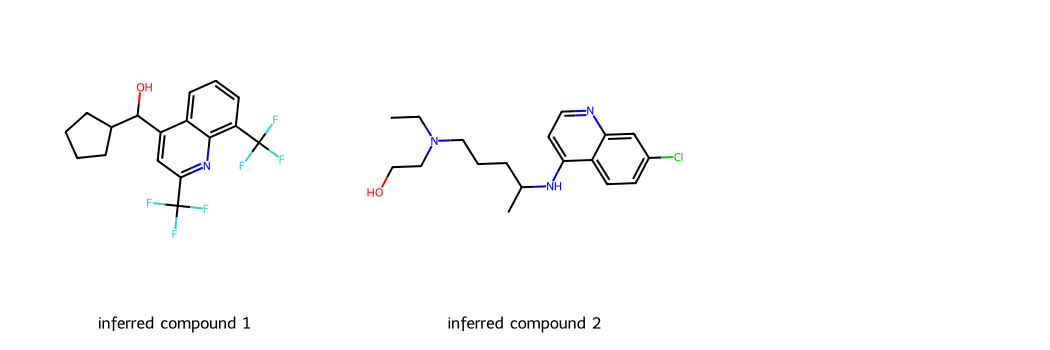

In [8]:
# First converting inferred SMILES to Mol object using RD-Kit
inf_1 = Chem.MolFromSmiles(inferred_smis[0])
inf_2 = Chem.MolFromSmiles(inferred_smis[1])

# ...followed by drawing them as 2-D structures
Draw.MolsToGridImage((inf_1,inf_2),legends=["inferred compound 1","inferred compound 2"], subImgSize=(350,350))

<br><br><br>
Comparing these inferred compounds to the original input, we find that they are the same compounds. In the next section, you will learn how to generate compounds similar to, but distinct from the input molecules.
<br><br>
__This concludes the first objective of evaluating the inference functionalities of BioNeMo_MolMIM.__

<a href='#contents'> __[Go to the top]__</a>

<a id='section2'></a>

## Molecule generation and chemical space exploration

In this section, we will use the pretrained BioNeMo-MolMIM model to generate designs of novel small-molecules which are similar to the query compound(s). 

First, we obtain the hidden state representation for the query compounds using the __`seqs_to_hiddens`__ functionality, as described in the previous section.

Once the hidden state(s) are obtained, we will use the function __`chem_sample`__, as defined below, to manipulate the hidden states and decoding those to generate new chemical designs.

<br><br>
![MolMIM Molecule Generation](../images/MolMIM_molecule_generation_1.png)
<br><br><br>


### Define `chem_sample` - the generation function


The `chem_sample` function will take a query SMILES as an input, and will return a valid and unique set of generated SMILES.

__`chem_sample`__ function has two main components.

1. Obtain the hidden state representation for the input SMILES, perturb copies of this hidden states, and decode those perturbed hidden states to obtain new SMILES.
2. Using RDKit, check the uniqueness of the generated SMILES set and retain those that are valid SMILES.

In [9]:
# Importing PyTorch library (for more details: https://pytorch.org/)
import torch

# Defining the chemical sampling/generation function
def chem_sample(smis):
    # Note, we can control what kind of sampling we want to do using the sampling_kwargs dictionary. Since these are language models, we can use beam-search, top-k, or nucleus sampling.
    sampler_kwargs = {
        "beam_size": 3, "keep_only_best_tokens": True, "return_scores": False
    }
    num_samples = 20       # Maximum number of generated molecules per query compound
    scaled_radius = 0.7    # Radius of exploration [range: 0.0 - 1.0] --- the extent of perturbation of the original hidden state for sampling
    population_samples = model.sample(seqs=smis, num_samples=num_samples, scaled_radius=scaled_radius, sampling_method="beam-search-perturbate", **sampler_kwargs)
    assert len(population_samples) == len(smis)
    assert len(population_samples[0]) == num_samples
    # There are len(smis) different samples, each of which is length num_samples, let's uniquify them and remove invalid ones
    uniq_canonical_smiles = []
    for smis_samples, original in zip(population_samples, smis):
        smis_samples = set(smis_samples) - set([original])  # unique strings that are not the same as we started from
        valid_molecules = []
        for smis in smis_samples:
            mol = Chem.MolFromSmiles(smis)
            if mol:
                valid_molecules.append(Chem.MolToSmiles(mol,True))
        uniq_canonical_smiles.append(valid_molecules)
    return uniq_canonical_smiles

### Generating analogous small molecules and visualizing them


In this step, we will use the same two example drug molecules -- mefloquine and hydroxychloroquine -- for generating new analogues. 

In [10]:
# The example SMILES for two widely used Antimalarial drugs -- mefloquine and hydroxychloroquine
smis_lst = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# Using the chem_sample function and providing smis as input
gen_smis_lst = chem_sample(smis_lst)
for ori_smis, gen_smis in zip(smis_lst, gen_smis_lst):
        print(f"Original SMILES: {ori_smis}")
        print(f"Generated {len(gen_smis)} unique/valid SMILES: {gen_smis}")
        print("\n")

[NeMo I 2024-03-22 16:17:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


Original SMILES: OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1
Generated 17 unique/valid SMILES: ['OCc1ncc(C(F)(F)F)nc1N(CC(F)(F)F)C1CC1', 'O[C@@H](c1cc(C(F)(F)F)ncn1)C(F)(F)Br', 'OC(c1c(NC[C@H]2CCOC2)nc2ccccn12)(C1CC1)C1CC1', 'OC(=NC[C@@H](N1CCOCC1)C(F)(F)F)N1C[C@H]2CNC[C@H]2C1', 'OC(c1ccc[nH]1)c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12', 'OC(C1CC1)C1CCN(Cc2cccc(C3OCCO3)c2)CC1', 'C[C@H]([C@@H](C)NC(=O)C(=O)N1CCC(F)(F)C1)N(C)CCCN(C)C', 'OC(c1ccccc1)(c1cc(C(F)(F)F)ncn1)c1cccs1', 'OC(c1cc[nH]n1)c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12', 'OCc1ncc(C(F)(F)F)nc1N(C[C@H]1CCCO1)CC(F)(F)F', 'OCc1ccc(C(F)(F)F)nc1N(Cc1ccccc1)c1ccccc1', 'O=C(O)C(F)(F)CCCNS(=O)(=O)c1ccccc1', 'OC(c1csc(Br)c1)c1cc(C(F)(F)F)ncn1', 'OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCC1', 'OC(c1cc(C(F)(F)F)ncc1Cl)(C(F)F)N1CCCCCC1', 'OC(c1cc(C(F)(F)F)ns1)C(F)(F)F', 'OC[C@@H]1C[C@H](NC(F)(F)F)C12CCC2']


Original SMILES: CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12
Generated 14 unique/valid SMILES: ['CCN(CCO)CCNC(=O)N1CCN2c3c(Cl)cccc3C[C@H]2C1', 'CCN(C

<br> Now, we will take a look at the generated designs. 

First lets visualize the generated designs analogous to the first query (mefloquine).

Total unique molecule designs obtained:  17


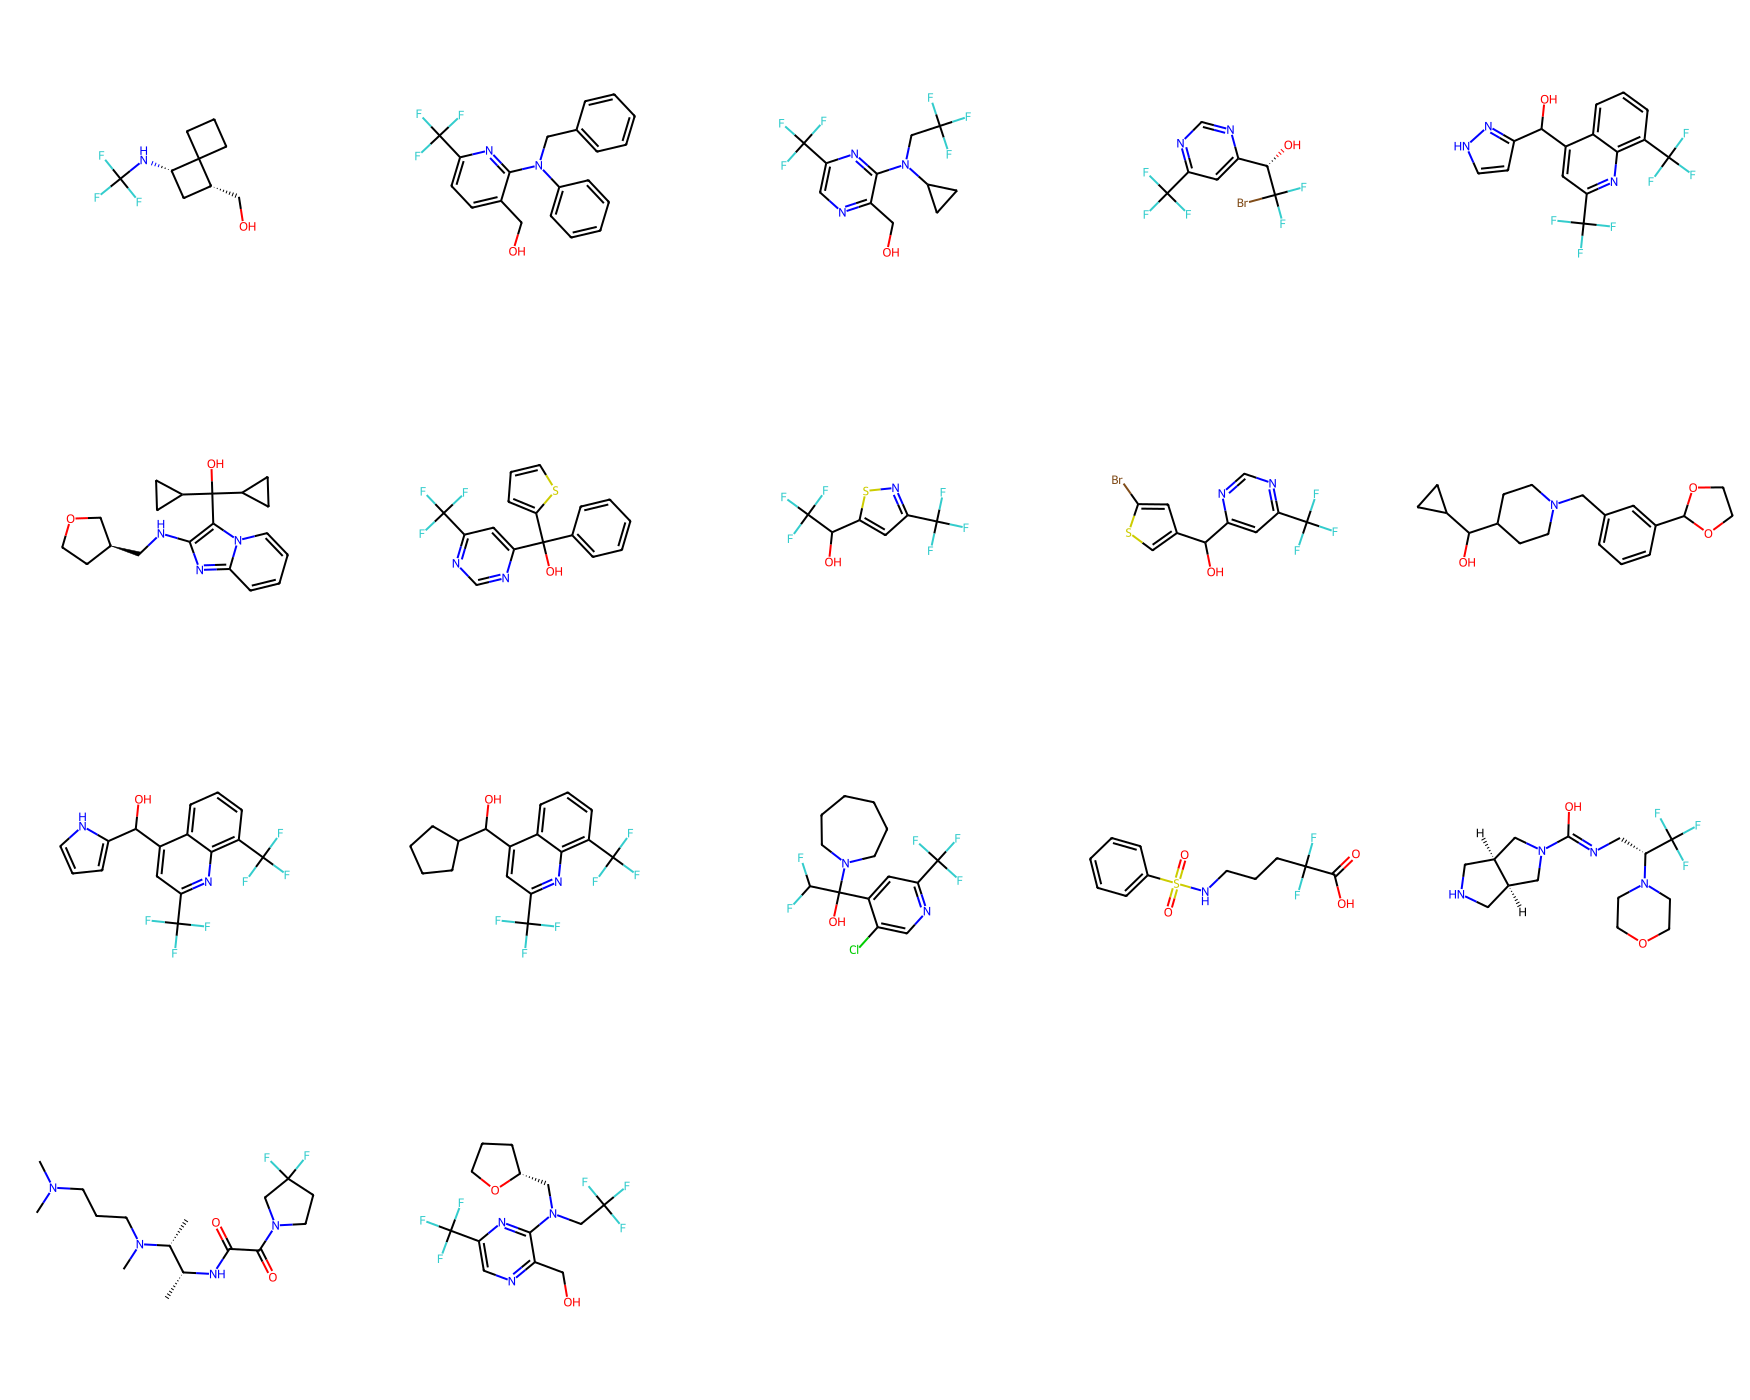

In [11]:
mols_from_gen_smis = [Chem.MolFromSmiles(smi) for smi in set(gen_smis_lst[0])]
print("Total unique molecule designs obtained: ", len(mols_from_gen_smis))
Draw.MolsToGridImage(mols_from_gen_smis, molsPerRow=5, subImgSize=(350,350))

And now from the second molecule (hydroxychloroquine).

Total unique molecule designs obtained:  14


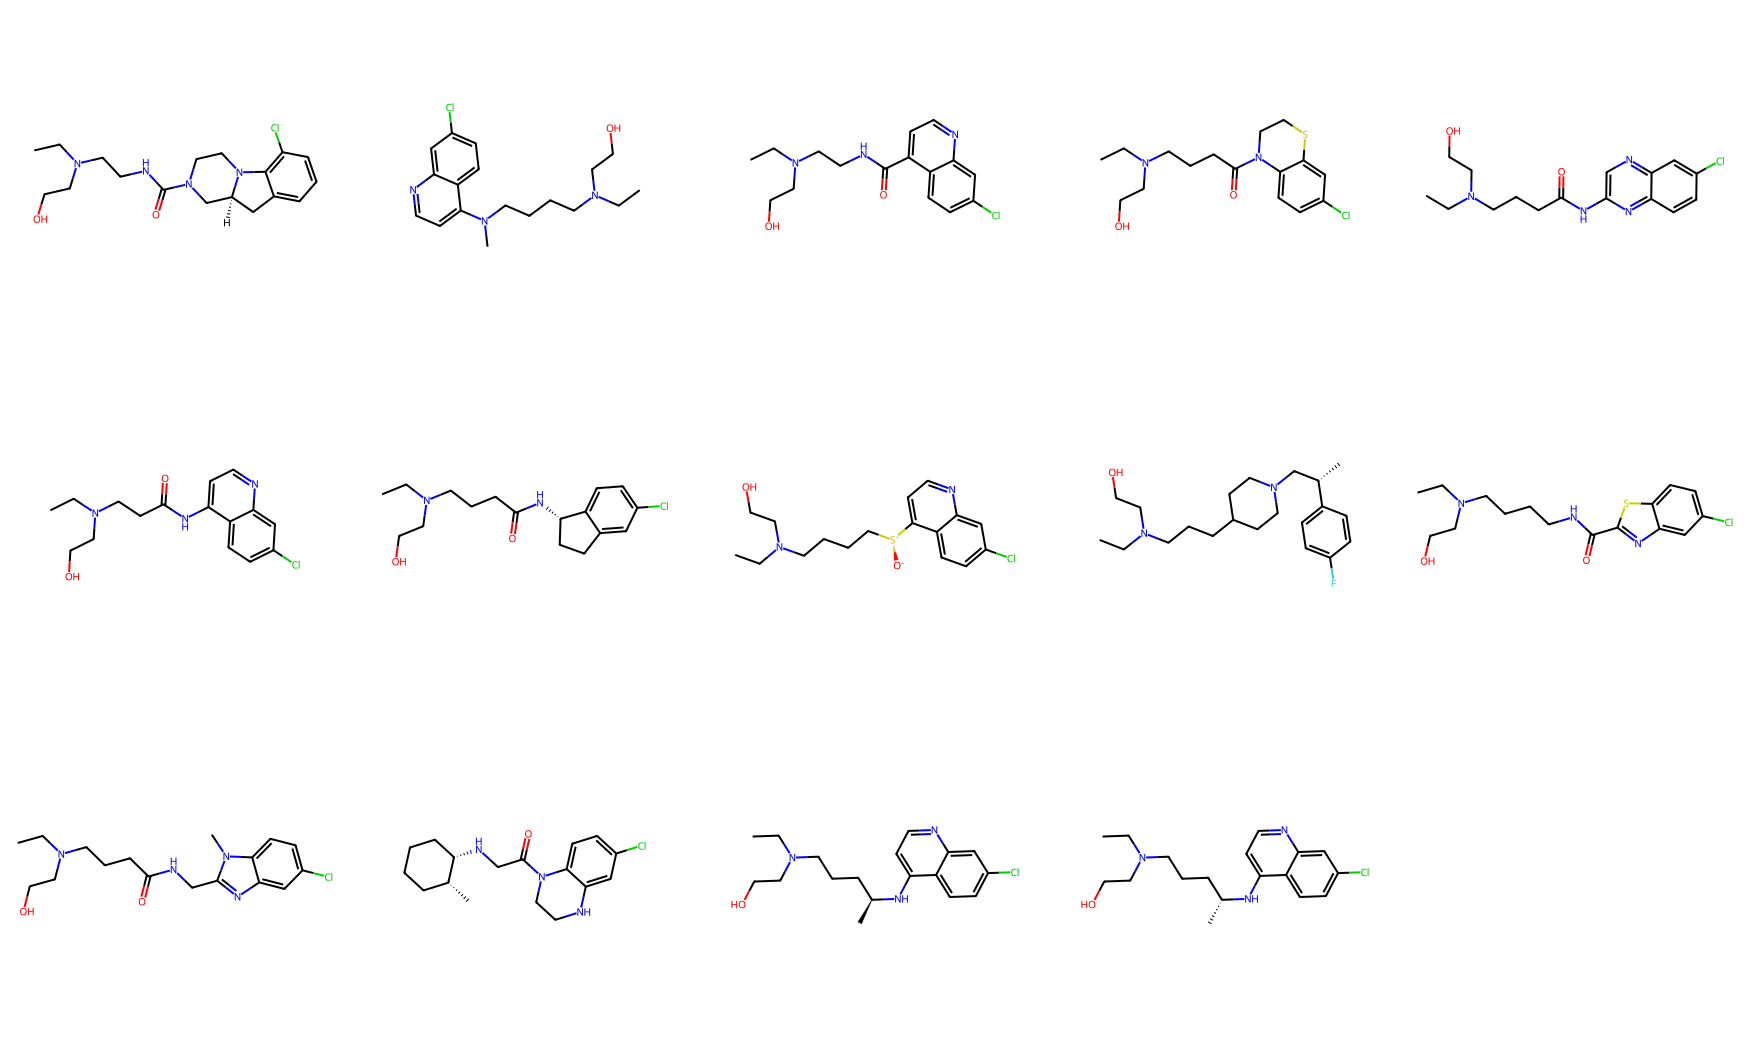

In [12]:
mols_from_gen_smis = [Chem.MolFromSmiles(smi) for smi in set(gen_smis_lst[1])]
print("Total unique molecule designs obtained: ", len(mols_from_gen_smis))
Draw.MolsToGridImage(mols_from_gen_smis, molsPerRow=5, subImgSize=(350,350))

<br><br><br>

How many molecular designs were obtained from this step? 

What would change in the process if you try different values for _number of samples_ and _sampling radius_ in the __`chem_sample`__ function? 


__This concludes the Second objective of using the BioNeMo-MolMIM pre-trained model for chemical space exploration and generative chemistry.__


<a href='#contents'> __[Go to the top]__</a>

***

<a id='section3'></a>

## Downstream Prediction Model using Learned Embeddings from Pre-trained Model 

One of the improtant tasks for chemoinformaticians is to develop models to predict properties of small molecules. 

These properties may include physicochemical parameters, such as lipophilicity, solubility, hydration free energy (LogP, LogD, and so on). These properties can also include certain pharmacokinetic/dynamic behaviors such as Blood-Brain-Barrier/CNS permeability, Vd, etc. 

Modeling such properties relies on the selection of appropriate and relevant descriptors/features. In this section, we will use the embeddings from MolMIM as a feature set for training a machine learning model for physico-chemical parameter predictions. We will then compare how this model performs when compared to a model developed using chemical fingerprints (here, _Morgan Fingerprints_). 

In the section below, we use the ESOL dataset curated by MoleculeNet (https://moleculenet.org/datasets-1)

* **ESOL**: Water solubility data(log solubility in mols per litre) for common organic small molecules [n=1129]

<br><br>
![mmb_2](../images/MMB_molecule_generation_2.png)
<br><br><br>

### Example: Compound Water Solubility (ESOL) Prediction

In this example, we will use the __ESOL__ dataset from Moleculenet. The dataset is modified for this example purposes to include the relevant columns and placed in __`/data`__ directory as __`benchmark_MoleculeNet_ESOL.csv`__.

We will load the data from `benchmark_MoleculeNet_ESOL.csv` file in a _cuDF_ dataframe format. After loading the data, we will obtain the embeddings for compounds that are present in the [cuDF](https://github.com/rapidsai/cudf) dataframe by using the previously introduced __`seqs_to_embedding`__ function of the BioNeMo-MolMIM pretrained model.

Similarly, we will obtain _Morgan Fingerprints_ for the compounds in the dataframe using RDKit's __`AllChem.GetMorganFingerprintAsBitVect`__ function.

Finally, we will generate two _Support Vector Regression_ models -- using the embeddings and the _Morgan Fingerprints_ -- with functions from the [cuML](https://github.com/rapidsai/cuml) library. At the end, we will compare the performances of both the models. 

###  Preprocessing dataset using cuDF

In [13]:
# Reading the benchmark_MoleculeNet_ESOL.csv file as cuDF DataFrame format
ex_data_file = './benchmark_MoleculeNet_ESOL.csv'
ex_df = cudf.read_csv(ex_data_file)

# Checking the dimensions of the dataframe and the first few rows
print(ex_df.shape)
ex_df.head()

(1128, 4)


,index,task,SMILES,measured log solubility in mols per litre
0,0,ESOL,Cc1cccc(C)c1O,-1.290
1,1,ESOL,ClCC(Cl)(Cl)Cl,-2.180
2,2,ESOL,CC34CCC1C(=CCc2cc(O)ccc12)C3CCC4=O,-5.282
3,3,ESOL,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,4,ESOL,CCCCCCCC(=O)C,-2.580


#### Obtaining the embeddings using __`seqs_to_embedding`__ 

In [14]:
%%time
# Generating embeddings for the compounds in the dataframe. 
# We process batches of 100 compounds at a time.
start = 0
ex_emb_df = cudf.DataFrame()
while start < ex_df.shape[0]:
    smis = ex_df.iloc[start: start+100, 2]
    x_val = ex_df.iloc[start: start+100, 3]
    embedding = model.seq_to_embeddings(smis.to_arrow().to_pylist())
    ex_emb_df = cudf.concat([ex_emb_df,
                             cudf.DataFrame({"SMILES": smis,
                                             "EMBEDDINGS": embedding.tolist(),
                                             "Y": x_val})])                   # The ESOL value is captured in the 'Y' column
    start = start + 100

CPU times: user 321 ms, sys: 13.4 ms, total: 335 ms
Wall time: 325 ms


We can now examine at the new column added with the embedding vectors.

In [15]:
ex_emb_df

,SMILES,EMBEDDINGS,Y
0,Cc1cccc(C)c1O,"[0.025419697165489197, 0.3563258945941925, -0....",-1.290
1,ClCC(Cl)(Cl)Cl,"[0.3793778419494629, -0.0816623866558075, 0.50...",-2.180
2,CC34CCC1C(=CCc2cc(O)ccc12)C3CCC4=O,"[-0.9475264549255371, -0.1938450038433075, -0....",-5.282
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[-0.2649092674255371, -0.1303684413433075, 0.1...",-7.870
4,CCCCCCCC(=O)C,"[0.1050858348608017, 0.3077419102191925, 0.017...",-2.580
...,...,...,...
1123,OCCCC=C,"[0.2729325294494629, 0.2718532383441925, 0.049...",-0.150
1124,Clc1ccccc1I,"[-0.2469649463891983, -0.0941135585308075, -0....",-3.540
1125,CCC(CC)C=O,"[0.0904373973608017, -0.4945041835308075, 0.35...",-1.520
1126,Clc1ccc(Cl)cc1,"[0.1441483348608017, -0.3509494960308075, -0.0...",-3.270


#### Obtaining the _Morgan Fingerprints_ using RDKit functionalities

In [16]:
%%time
# Here, we will define a function to return Morgan Fingerprints for a list of input SMILES
def get_fp_arr(df_smi):
    fp_array = []
    for smi in df_smi:
        m = Chem.MolFromSmiles(smi)                               # Converting SMILES to RD-Kit's MOL format
        fp =  AllChem.GetMorganFingerprintAsBitVect(m, 3, 1024)   # Obtain Morgan Fingerprints as a Bit-vector
        fp = np.fromstring(fp.ToBitString(), 'u1') - ord('0')     # Converting Bit-vector to string type
        fp_array.append(fp)
    fp_array = np.asarray(fp_array)
    return fp_array.tolist()

# Passing the SMILES list to the get_fp_arr function, and saving the returned list of Morgan Fingerprints as a DataFrame column named 'FINGERPRINTS'
ex_emb_df['FINGERPRINT'] = get_fp_arr(ex_emb_df['SMILES'].to_arrow().to_pylist())

# Let's take a look at the DataFrame after Morgan_Fingerprint calculation
ex_emb_df

CPU times: user 164 ms, sys: 31.3 ms, total: 195 ms
Wall time: 182 ms


,SMILES,EMBEDDINGS,Y,FINGERPRINT
0,Cc1cccc(C)c1O,"[0.025419697165489197, 0.3563258945941925, -0....",-1.290,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ClCC(Cl)(Cl)Cl,"[0.3793778419494629, -0.0816623866558075, 0.50...",-2.180,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC34CCC1C(=CCc2cc(O)ccc12)C3CCC4=O,"[-0.9475264549255371, -0.1938450038433075, -0....",-5.282,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[-0.2649092674255371, -0.1303684413433075, 0.1...",-7.870,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CCCCCCCC(=O)C,"[0.1050858348608017, 0.3077419102191925, 0.017...",-2.580,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
1123,OCCCC=C,"[0.2729325294494629, 0.2718532383441925, 0.049...",-0.150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1124,Clc1ccccc1I,"[-0.2469649463891983, -0.0941135585308075, -0....",-3.540,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1125,CCC(CC)C=O,"[0.0904373973608017, -0.4945041835308075, 0.35...",-1.520,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1126,Clc1ccc(Cl)cc1,"[0.1441483348608017, -0.3509494960308075, -0.0...",-3.270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


###  Generating ML models using cuML

Now that we have both the embeddings and the Morgan Fingerprints calculated for the ESOL dataset, we can use the _cuML_ to generate a prediction model.

Here, we will be creating a _Support Vector Regression_ model. For more details, refer to https://docs.rapids.ai/api/cuml/stable/api.html#support-vector-machines.
<br><br>
First, let's make a model using _Morgan Fingerprints_:

In [17]:
### Using Morgan fingerprints for developing a Support Vector Regression prediction model ###

# Splitting the input dataset into Training (70%) and Test sets(30%)
tempX = cp.asarray(ex_emb_df['FINGERPRINT'].to_arrow().to_pylist(), dtype=cp.float32)
tempY = cp.asarray(ex_emb_df['Y'], dtype=cp.float32)
x_train, x_test_mfp, y_train, y_test_mfp  = cuml.train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining Support vector regression model parameters 
reg_mfp = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)     # You may change the model parameters and observe the change in the performance

# Fitting the model on the training dataset
reg_mfp.fit(x_train, y_train)
SVR()

# Using the fitted model for prediction of the ESOL values for the test dataset compounds
pred_mfp = reg_mfp.predict(x_test_mfp)

# Performance measures of SVR model - Mean Squared Error and R-squared values
mfp_SVR_MSE = cuml.metrics.mean_squared_error(y_test_mfp, pred_mfp)
mfp_SVR_R2 = cuml.metrics.r2_score(y_test_mfp, pred_mfp)

print("Fingerprint_SVR_MSE: ", mfp_SVR_MSE)
print("Fingerprint_SVR_r2: ", mfp_SVR_R2)

Fingerprint_SVR_MSE:  1.1670269
Fingerprint_SVR_r2:  0.740040123462677


<br><br>
Now, we can use BioNeMo-MolMIM Embeddings to develop a Support Vector Regression prediction model.

In [18]:
### Using BioNeMo-MolMIM Embeddings for developing a SVR model ###

# Splitting dataset into training and testing sets
tempX = cp.asarray(ex_emb_df['EMBEDDINGS'].to_arrow().to_pylist(), dtype=cp.float32)
tempY = cp.asarray(ex_emb_df['Y'], dtype=cp.float32)
x_train, x_test_emb, y_train, y_test_emb  = cuml.train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining Support vector regression model parameters 
reg_emb = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)    # You may change the model parameters and observe the change in the performance

# Fitting the model on the training dataset
reg_emb.fit(x_train, y_train)

# Using the fitted model for prediction of the ESOL values for the test dataset compounds
pred_emb = reg_emb.predict(x_test_emb)

# Performance measures of SVR model
emb_SVR_MSE = cuml.metrics.mean_squared_error(y_test_emb, pred_emb)
emb_SVR_R2 = cuml.metrics.r2_score(y_test_emb, pred_emb)

print("Embeddings_SVR_MSE: ", emb_SVR_MSE)
print("Embeddings_SVR_r2: ", emb_SVR_R2)

Embeddings_SVR_MSE:  1.2011706
Embeddings_SVR_r2:  0.7324345111846924


<br><br>

Let's plot the MSE and R-squared values obtained for both the models.


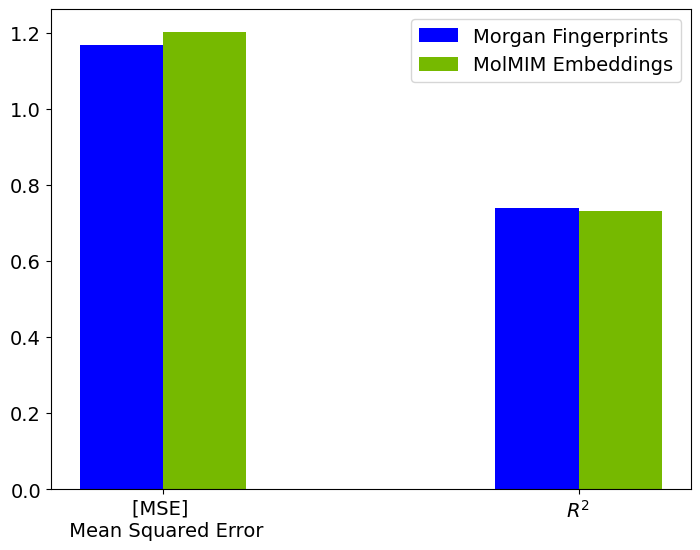

In [19]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
data = [[cp.asnumpy(mfp_SVR_MSE), mfp_SVR_R2],
[cp.asnumpy(emb_SVR_MSE), emb_SVR_R2]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.20)
ax.bar(X + 0.20, data[1], color = '#76b900', width = 0.20)
ax.set_xticks([0.1, 1.1])
ax.set_xticklabels(['[MSE] \n Mean Squared Error', '$R^2$'])
ax.legend(['Morgan Fingerprints', 'MolMIM Embeddings'],loc='best')

<br><br>

We can also examine the experimental and predicted ESOL values from both regressors trained on different featurizations.

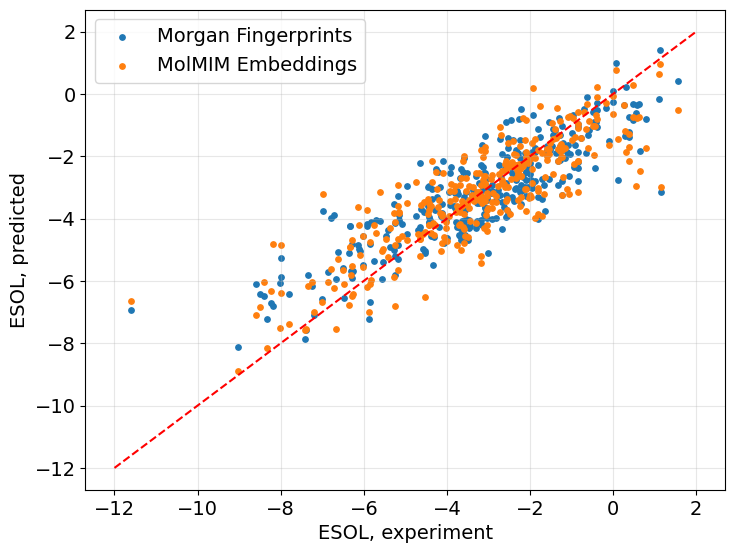

In [20]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(cp.asnumpy(y_test_mfp), cp.asnumpy(pred_mfp), s=15, label='Morgan Fingerprints')
ax.scatter(cp.asnumpy(y_test_mfp), cp.asnumpy(pred_emb), s=15, label='MolMIM Embeddings')
ax.grid(alpha=0.3)
ax.plot([-12, 2], [-12, 2], 'r--') # The "perfect prediction" line
ax.set_xlabel('ESOL, experiment')
ax.set_ylabel('ESOL, predicted')
ax.legend()

<br><br><br>

The overall performance of predictions made using the model trained with MolMIM embeddings is comparable to those predictions made with the Morgan Fingerprint-based model.

__This concludes the final objective of using the embeddings for predictive modeling of downstream tasks.__


<a href='#contents'> __[Go to the top]__</a>